# Deliverable 2
This is the notebook that has the second deliverable.

Table of Contents <br>

0. Import Modules
1. Data reading
2. Descriptive data analysis
3. Ways to enrich, filter, transform the data
4. Plan and Ideas for Methods

# 0. Import modules
Feel free to use the virtual environment (amonavis) included in the GitHub folder.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import statistics
import math

# networkx
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout


# For semantic similarity
from urllib.parse import unquote
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Python functions in .py file to read data
import data_readers

/Users/carolinaalbamaruganrubio/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data reading
The following code reads the data and saves them in the appropriate variables.
<br><br>
**Wikispeedia**
This will hold our graph where Wikipedia articles are nodes and links/paths between them are edges.

<br><br>
**finished_paths**
The datafile includes the hashedIpAddress, timestamp, durationInSec, path, and rating of games that were completed.
We also add columns with the first article (soruce), last article (target), path length (#articles), and a readable date in Timestamp format.

<br><br>
**unfinished_paths**
This datafile is similar to finished_paths, but with games that weren't completed. It has the hashedIpAddress, timestamp, durationInSec, path, target, and type of failure (either timeout or restart).

<br><br>
**articles**
Dataframe with the name of all articles in the dataset.

<br><br>
**categories**
This shows the higher category classification of each article. For example, Áedán mac Gabráin is part of 'subject.History.British_History.British_History_1500_and_before_including_Roman_Britain'

In [4]:
# The links and edges
wikispeedia = data_readers.read_wikispeedia_graph()

# The finished paths
finished_paths = data_readers.read_finished_paths()

# The unfinished paths
unfinished_paths = data_readers.read_unfinished_paths()

# DF of all articles
articles = data_readers.read_articles()

# DF of all articles and their categories
categories = data_readers.read_categories()


# We found out later that the data contained in the shortest path matrix given to us seems to be wrong
# Here we also add a quick dictionary that properly shows that this is wrong, and give an example
shortest_path_df = data_readers.read_shortest_path_df()
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# Searching for the string of a given article. It has to be formatted like the article name
# Which shouldn't be a problem, as we'll probably usually retrieve them internally
obi_wan_text = data_readers.plaintext_article_finder('Obi-Wan_Kenobi')

In [39]:
print("Dataset has", len(wikispeedia.nodes), "nodes")
print("Dataset has", len(wikispeedia.edges), "edges")

Dataset has 4592 nodes
Dataset has 119882 edges


These are less nodes than the reported number, it should be 4,604 nodes.

The 119,882 edges is correct though.

The difference is probably due to some nodes not being connected to the rest of the graph, as here we read in only the articles that are connected. The few nodes that we are losing do not matter for what we need.

In [40]:
# Let's print a sample of each dataframe to make sure they were read in correctly.
finished_paths.sample(5)

hashedIpAddress   timestamp  durationInSec  \
25299  6752f0163c9b4776  1249450031             61   
44615  240ebde0409c748a  1251242170             55   
1679   4dca8e1c78763d19  1352385390             98   
42992  49d124e70621d422  1249667270             14   
15348  0966eadd0f9dfd89  1249447044            465   

                                                    path  rating  \
25299                    Desert;Water;River;Murray_River     NaN   
44615  Pac-Man;Space_Invaders;Extraterrestrial_life;P...     1.0   
1679             Batman;Earthquake;Earth;Plant;Tree;Wood     NaN   
42992  Measurement;United_States;American_English;Eng...     NaN   
15348                          Eye;Human;Music;Art;Dance     2.0   

      first_article      last_article  path_length                date  
25299        Desert      Murray_River            4 2009-08-05 05:27:11  
44615       Pac-Man  Proxima_Centauri            5 2009-08-25 23:16:10  
1679         Batman              Wood            6 2012-11-08 14:36:30  
42992   Measurement  English_language            4 2009-08-07 17:47:50  
15348           Eye             Dance            5 2009-08-05 04:37:24

In [41]:
unfinished_paths.sample(5)

hashedIpAddress   timestamp  durationInSec  \
13306  77b1278668cd3361  1350340823              7   
22884  403476ce4ded3d01  1383224161            117   
16748  3d888a492c6d9b86  1360165672            286   
9801   30ccdde44f301813  1343364224              9   
22236  126c53a444812f50  1381237875             12   

                                                    path           target  \
13306                                           Aircraft           Google   
22884  Star_Trek__The_Original_Series;Star_Trek;Star_...  Popular_culture   
16748                  Greek_mythology;Carl_Jung;Basel;<         Antelope   
9801                                              Batman          Thorium   
22236                                            Pyramid             Bean   

          type  
13306  restart  
22884  restart  
16748  restart  
9801   restart  
22236  restart

In [42]:
articles.sample(5)

articles
4592                        Zhang_Qian
3163  Parliament_of_the_United_Kingdom
1583                   Franklin_Pierce
2865                           Mu_Arae
602                 Black-winged_Stilt

In [43]:
len(articles['articles'].unique()) == len(articles)
# The name of the articles is unique

True

In [91]:
categories.sample(5)

article  \
1418                     Durham   
1487                        NaN   
2652                   Kiribati   
4820  USS_Wisconsin_%28BB-64%29   
4973              War_and_Peace   

                                             categories  \
1418       subject.Geography.Geography_of_Great_Britain   
1487           subject.People.Monarchs_of_Great_Britain   
2652  subject.Geography.Geography_of_Oceania_Austral...   
4820           subject.History.Military_History_and_War   
4973             subject.Language_and_literature.Novels   

                      depth_1  
1418                Geography  
1487                   People  
2652                Geography  
4820                  History  
4973  Language_and_literature

In [45]:
shortest_path_df.head()

(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                                    0   
(%C3%85land,)                                                         -1   
(%C3%89douard_Manet,)                                                 -1   
(%C3%89ire,)                                                          -1   
(%C3%93engus_I_of_the_Picts,)                                         -1   

                                     (%C3%85land,)  (%C3%89douard_Manet,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)             -1                     -1   
(%C3%85land,)                                    0                     -1   
(%C3%89douard_Manet,)                           -1                      0   
(%C3%89ire,)                                    -1                     -1   
(%C3%93engus_I_of_the_Picts,)                   -1                     -1   

                                     (%C3%89ire,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)            -1   
(%C3%85land,)                                  -1   
(%C3%89douard_Manet,)                          -1   
(%C3%89ire,)                                    0   
(%C3%93engus_I_of_the_Picts,)                  -1   

                                     (%C3%93engus_I_of_the_Picts,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                             -1   
(%C3%85land,)                                                   -1   
(%C3%89douard_Manet,)                                           -1   
(%C3%89ire,)                                                    -1   
(%C3%93engus_I_of_the_Picts,)                                    0   

                                     (%E2%82%AC2_commemorative_coins,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                                 -1   
(%C3%85land,)                                                       -1   
(%C3%89douard_Manet,)                                               -1   
(%C3%89ire,)                                                        -1   
(%C3%93engus_I_of_the_Picts,)                                       -1   

                                     (10th_century,)  (11th_century,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                3                3   
(%C3%85land,)                                      2                2   
(%C3%89douard_Manet,)                              3                3   
(%C3%89ire,)                                       3                3   
(%C3%93engus_I_of_the_Picts,)                      2                2   

                                     (12th_century,)  (13th_century,)  ...  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                3                3  ...   
(%C3%85land,)                                      2                2  ...   
(%C3%89douard_Manet,)                              2                2  ...   
(%C3%89ire,)                                       3                3  ...   
(%C3%93engus_I_of_the_Picts,)                      3                2  ...   

                                     (Ziad_Jarrah,)  (Zimbabwe,)  (Zinc,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)               4            3        3   
(%C3%85land,)                                     4            2        3   
(%C3%89douard_Manet,)                             4            3        2   
(%C3%89ire,)                                      4            2        2   
(%C3%93engus_I_of_the_Picts,)                     4            2        3   

                                     (Zinc_chloride,)  (Zion_National_Park,)  \
(%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,)                 4                      4   
(%C3%85land,)                                       4                      4   
(%C3%89douard_Manet,)                               3                      4   
(%C3%89ire,)                                        3                      4   
(%C3%93engus_I_of_the_Picts,)                       4                      4   

                                     (Zionism,)  (Zirconium,)  (Zoroaster,)  \
(

# 2. Descriptive Data Analysis
Here, we show that we understand what’s in the data (formats, distributions, missing values, correlations, etc.).


In this section:
<br>2.1. How many articles there are, how many paths 
<br>2.2. Histograms of the links from each article (for example, how many articles have 20 links, etc)
<br>2.3. PageRank
<br>2.4. Average distance from one article to any other article
<br>2.5. Histogram of the number of games at each point in time
<br>2.6. Understanding unfinished games: Categories of targets in unfinished games
<br>2.7. Issue with the shortest path
<br>2.8. Study of Unique paths
<br>2.9. Study of hubs
<br>2.10. DataFrame and spreadsheet creation 

### 2.1. How many: articles, links, finished games, unfinished games?


In [46]:
print("There are", len(wikispeedia.nodes), "articles in the dataset.")
print("There are", len(wikispeedia.edges), "links/paths.")
print("There are", finished_paths.shape[0], "finished games.")
print("There are", unfinished_paths.shape[0], "unfinished games.")

There are 4592 articles in the dataset.
There are 119882 links/paths.
There are 51318 finished games.
There are 24875 unfinished games.


In [47]:
unique_paths = finished_paths['path'].unique()
print('There are', len(unique_paths), 'unique finshed paths.')

There are 47856 unique finshed paths.


### 2.2. Degree of a Node
The degree of a node is the number of edges/links it has. We plot a complementary cumulative distribution function (CCDF) of degree for each article/node.

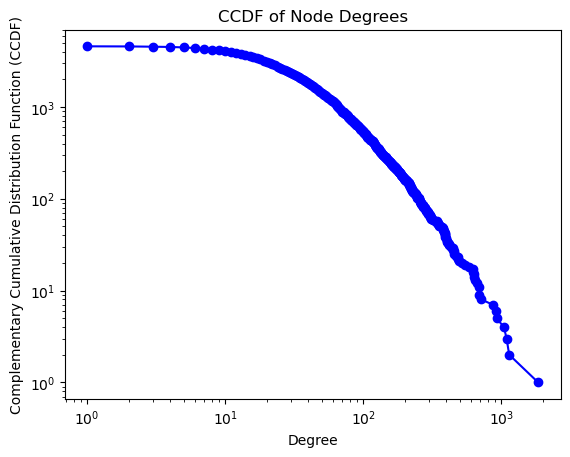

In [48]:
# Get the degrees of all nodes
degrees = dict(wikispeedia.degree())

# Calculate the CCDF
degree_values = sorted(set(degrees.values()), reverse=True)
ccdf = [sum(1 for degree in degrees.values() if degree >= d) for d in degree_values]

# Plot the CCDF
plt.plot(degree_values, ccdf, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
plt.title('CCDF of Node Degrees')
plt.show()

What are the "hubs"? Which nodes have more than 500 links?

In [49]:
print("Nodes with more than 1000 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 1000])
print("Nodes with more than 500 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 500])


Nodes with more than 1000 edges:  ['United_Kingdom', 'France', 'United_States', 'Europe']
Nodes with more than 500 edges:  ['Russia', 'United_Kingdom', 'World_War_II', 'France', 'Germany', 'Italy', 'Canada', 'English_language', 'England', 'Spain', 'United_States', 'India', 'China', 'Europe', 'Australia', 'Japan', 'London', 'Africa', 'Animal', 'Scientific_classification']


Observe that biggest hubs are mainly countries. The 'United Kingdom', 'France', 'United States', and 'Europe' have over 1000 links. Since there are 4592 nodes, these nodes have link to almost 1/4 of the dataset!

How many nodes have more than 20 links? How many have only 1 link?

In [50]:
# Count the number of nodes with degree 1
nodes_degree_1 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) == 1]
print('Nodes with degree 1: ', nodes_degree_1)

# Get the percentages
total_nodes = len(wikispeedia.nodes)
percentage_degree_1 = (len(nodes_degree_1) / total_nodes)
print('% of nodes that have only 1 edge/link:', percentage_degree_1)

# Count number of nodes with degree <= 20
nodes_degree_20 = sum(1 for degree in degrees.values() if degree <= 20)
print('% of nodes that have 20 or less edges/links:', nodes_degree_20 / total_nodes)

Nodes with degree 1:  ['All_your_base_are_belong_to_us', 'Local_community', 'Dewey_Square', 'Emma_Roberts', 'Human_abdomen', 'Pere_Marquette_1225', 'Pro_Milone', 'Sunol_Water_Temple', 'T._D._Judah', 'Terik', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'White_Mountain_art']
% of nodes that have only 1 edge/link: 0.0028310104529616726
% of nodes that have 20 or less edges/links: 0.344294425087108


### 2.3. PageRank

PageRank Dictionary: {key: value} -> {'article_title': pagerank}

In [51]:
dic = nx.pagerank(wikispeedia)
print(dic)

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': 3.2710390395592254e-05, 'Bede': 0.00021938161316650256, 'Columba': 0.00012116881897593145, 'D%C3%A1l_Riata': 0.00010556015467803797, 'Great_Britain': 0.0015061292462843425, 'Ireland': 0.0018999654148516224, 'Isle_of_Man': 0.00046032088563309313, 'Monarchy': 0.0008133221072287704, 'Orkney': 0.00028994588516574057, 'Picts': 0.00019759121101826143, 'Scotland': 0.0021425304277849183, 'Wales': 0.0010997632074287427, '%C3%85land': 3.2710390395592254e-05, '20th_century': 0.002361539066403613, 'Baltic_Sea': 0.0006497932466591777, 'Crimean_War': 0.00022012926646383522, 'Currency': 0.003237155919656553, 'Euro': 0.001249533710187169, 'European_Union': 0.002318582455038707, 'Finland': 0.001009621435681574, 'League_of_Nations': 0.0005769703027683626, 'List_of_countries_by_system_of_government': 0.0028333266533963103, 'Nationality': 0.00022617861790487603, 'Parliamentary_system': 0.000721430277649281, 'Police': 0.00025282362854375833, 'Russia': 0.0034961316179664

Assign pagerank as a node attribute of Wikispeedia graph

In [52]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['pagerank'] = dic[node]
print(wikispeedia.nodes(data=True))

[('%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', {'pagerank': 3.2710390395592254e-05}), ('Bede', {'pagerank': 0.00021938161316650256}), ('Columba', {'pagerank': 0.00012116881897593145}), ('D%C3%A1l_Riata', {'pagerank': 0.00010556015467803797}), ('Great_Britain', {'pagerank': 0.0015061292462843425}), ('Ireland', {'pagerank': 0.0018999654148516224}), ('Isle_of_Man', {'pagerank': 0.00046032088563309313}), ('Monarchy', {'pagerank': 0.0008133221072287704}), ('Orkney', {'pagerank': 0.00028994588516574057}), ('Picts', {'pagerank': 0.00019759121101826143}), ('Scotland', {'pagerank': 0.0021425304277849183}), ('Wales', {'pagerank': 0.0010997632074287427}), ('%C3%85land', {'pagerank': 3.2710390395592254e-05}), ('20th_century', {'pagerank': 0.002361539066403613}), ('Baltic_Sea', {'pagerank': 0.0006497932466591777}), ('Crimean_War', {'pagerank': 0.00022012926646383522}), ('Currency', {'pagerank': 0.003237155919656553}), ('Euro', {'pagerank': 0.001249533710187169}), ('European_Union', {'pagerank': 0.0023185824

Average PageRank

In [53]:
average = sum(dic.values()) / len(dic)
print(average)

0.00021777003484320113


In [54]:
above_average = {key: value for key, value in dic.items() if value >= average}

In [55]:
num_elements_above_avg = len(above_average)
print("Number of elements above average")
print(num_elements_above_avg)

Number of elements above average
1134


Median PageRank

In [56]:
values = list(dic.values())
median = statistics.median(values)
print(median)

8.689532387656443e-05


In [57]:
# order dictionary to visualize articles following plot
above_median = {key: value for key, value in dic.items() if value >= median}
above_median_ordered = {k: v for k, v in sorted(above_median.items(), key=lambda item: item[1], reverse=True)}

In [58]:
num_elements_above_median = len(above_median)
print('Number of elements above average median')
print(num_elements_above_median)

Number of elements above average median
2296


#### PageRank in descending order of the articles above the median (50% data)

In [59]:
names = list(above_median_ordered.keys())
values = list(above_median_ordered.values())

plt.figure(figsize=(30, 350))
sns.barplot(x=values, y=names, palette='viridis')
plt.xlabel('PageRank')
plt.ylabel('Articles')
plt.title('PageRank Classification of Wikispeedia Articles above the Wikispeedia median PageRank')
plt.show()

### 2.4. Average Distance between Articles
On average, how many links/edges does it take to connect any random two articles?

In [60]:
# Our graph is not strongly connected, meaning it's not possible to reach every node from every other node
# So we can't use the built in function nx.average_shortest_path_length

# This takes a long time to run (30 sec)
shortest_paths = list(nx.all_pairs_shortest_path_length(wikispeedia))
reachable_pairs = [(source, target, length) for source, paths in shortest_paths for target, length in paths.items() if length != float('inf')]
total_distances = sum(length for _, _, length in reachable_pairs)
average_distance = total_distances / len(reachable_pairs) if reachable_pairs else 0
print(f"Average distance between reachable nodes: {average_distance:.2f}")


Average distance between reachable nodes: 3.20


### 2.5. Games per Time
Histogram of the number of games at each point in time.


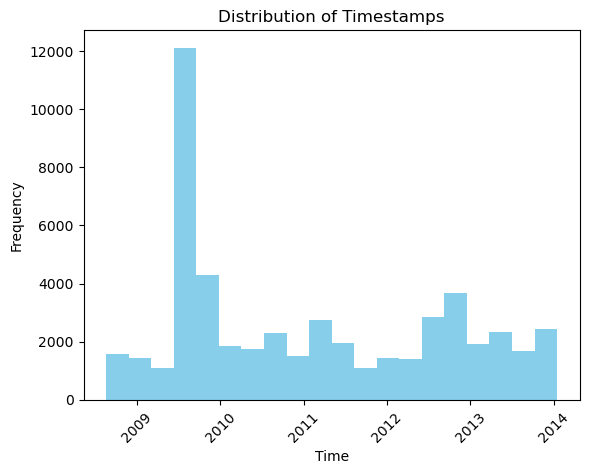

In [61]:
# Convert timestamps to datetime objects
timestamps = finished_paths['timestamp']
date_times = [datetime.utcfromtimestamp(ts) for ts in timestamps]

# Create a histogram of timestamps
plt.hist(date_times, bins=20, color='skyblue')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

A lot of games were played in Q3 2009! 

In [62]:
q3_2009_times = [dt for dt in date_times if dt.year == 2009 and dt.month in [7, 8, 9]]
percent_q3_2009_times = len(q3_2009_times) / len(date_times)
print(f"Percent of finished games completed in Q3 2009: {percent_q3_2009_times:.2f}")


Percent of finished games completed in Q3 2009: 0.24


### 2.6. Which categories of games are more likely to be unfinished? 

In [63]:
print('There are', categories['article'].duplicated().sum(), 'articles with more than 1 category.')

print('Should we drop the duplicate categories, or doublecount them?')
print('This corresponds to', categories['article'].duplicated().sum() / len(wikispeedia.nodes), 'of the articles.')

# Let's drop them for now.
categories['article'] = categories['article'].drop_duplicates()
print('The new shape is: ',categories.shape)

# Why are there more articles here than nodes (# articles)?

There are 606 articles with more than 1 category.
Should we drop the duplicate categories, or doublecount them?
This corresponds to 0.13196864111498258 of the articles.
The new shape is:  (5204, 2)


In [64]:
# Let's use string manipulation to extract the highest level category for each article.

sub_categories = categories['categories'].str[8:].str.split('.')
category_depth_1 = sub_categories.apply(lambda x: x[0])
categories['depth_1'] = category_depth_1
categories.head()

article  \
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   
1                               NaN   
2                        %C3%85land   
3                               NaN   
4                %C3%89douard_Manet   

                                          categories    depth_1  
0  subject.History.British_History.British_Histor...    History  
1                  subject.People.Historical_figures     People  
2                                  subject.Countries  Countries  
3  subject.Geography.European_Geography.European_...  Geography  
4                             subject.People.Artists     People

Let's find the category corresponding to each unfinished target.

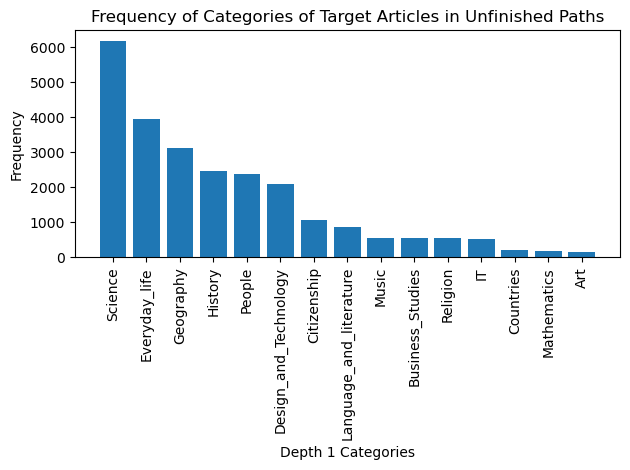

In [65]:
# Merging categories with unfinished paths.
unfinished_paths_with_categories = pd.merge(unfinished_paths, categories, left_on = 'target', right_on= 'article', how = 'left')

# Count the occurrences of each category
category_counts = unfinished_paths_with_categories['depth_1'].value_counts()

# Plotting the bar chart
plt.bar(category_counts.index, category_counts.values)

# Adding labels and title
plt.xlabel('Depth 1 Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Categories of Target Articles in Unfinished Paths')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the plot area

Notice that targets in the science category make up the largest proportion of unfinished games. In Deliverable 3, we will investigate this more. We'll discover if this is because most of the articles are from the science category, or if science articles are actually harder to find in the game.

### 2.7 Issue with the shortest path
The shortest paths that were calculated are wrong. This is just a simple example to show that at least one of the points is wrong. We assume this is common enough elsewhere, as the effort needed to properly prove this is too large.

We double-checked the method for reading in the data, and there are no big changes to be done there. We also double-checked that the graph is a directed graph, which matters for this search. Additionally, we manually checked the edges, so we know that the following example is correct.

In [66]:
# We have to put the strings into tuples to make this work. It's ugly, but this works
print("Shortest path from Actor to Japan in the given matrix is:", shortest_path_df[('Actor',)][('Japan',)])

print("Shortest path from Actor to Japan according to networkX is:", len(shortest_path_dict['Actor']['Japan'])-1)

print("The actual path is:", shortest_path_dict['Actor']['Japan'])

Shortest path from Actor to Japan in the given matrix is: 3
Shortest path from Actor to Japan according to networkX is: 1
The actual path is: ['Actor', 'Japan']


In [67]:
# No need to print the entire text, just show that reading it in works
obi_wan_text[:100]

'   #copyright\n\nObi-Wan Kenobi\n\n2007 Schools Wikipedia Selection. Related subjects: Films\n\n   Star Wa'

### 2.8. Study of Unique Paths
Here we study the unique source and target pairs. We will use the dataframes to compare the performance between humans and machines, as well as to know what paths to make machines complete.

**article_combinations**

This dataframe contains information on all the combination of source and target articles in the finished games (paths). It includes how many times it has been played, and the mean and std of the path length, duration of the game, and rating.

**unique_targets** and **unique_sources**

These dataframes include all the sources and targets that appears in the finished games

<br><br>
Note that we don't change to ASCII the name of the articles yet. We will do it at a later step if we need to.
<br><br>

In [68]:
# How many each pair of articles has been visited
article_combinations_count = finished_paths.groupby(['first_article', 'last_article']).size().reset_index(name='count')

# The mean and std of the path length for each pair of articles
article_combinations_stats = finished_paths.groupby(['first_article', 'last_article'])['path_length'].agg(['mean', 'std']).reset_index()
article_combinations_stats['std'] = article_combinations_stats['std'].fillna(0)
article_combinations_stats.rename(columns={'mean': 'mean_length', 'std': 'std_length'}, inplace=True)

# The mean and std of the rating for each pair of articles. 
    # Note that mean and std may be nan if there are nan ratings. We purposely leave them as nan, as we don't want to fill them with 0s or 1s.
    # Depending on the application, we could change this in the future if neeeded.
rating_combinations_stats_rating = finished_paths.groupby(['first_article', 'last_article'])['rating'].agg(['mean', 'std']).reset_index()
#rating_combinations_stats_rating['std'] = rating_combinations_stats_rating['std'].fillna(0)
mask = rating_combinations_stats_rating['mean'].notnull()
rating_combinations_stats_rating.loc[mask, 'std'] = rating_combinations_stats_rating.loc[mask, 'std'].fillna(0)
rating_combinations_stats_rating.rename(columns={'mean': 'mean_rating', 'std': 'std_rating'}, inplace=True)

# The mean and std of the time for each pair of articles.
rating_combinations_stats_time = finished_paths.groupby(['first_article', 'last_article'])['durationInSec'].agg(['mean', 'std']).reset_index()
rating_combinations_stats_time['std'] = rating_combinations_stats_time['std'].fillna(0)
rating_combinations_stats_time.rename(columns={'mean': 'mean_durationInSec', 'std': 'std_durationInSec'}, inplace=True)

# Merging all the dataframes
article_combinations = pd.merge(article_combinations_count, article_combinations_stats, on=['first_article', 'last_article'])
article_combinations = pd.merge(article_combinations, rating_combinations_stats_rating, on=['first_article', 'last_article'])
article_combinations = pd.merge(article_combinations, rating_combinations_stats_time, on=['first_article', 'last_article'])

# The number of unique sources and targets
unique_sources = finished_paths['first_article'].value_counts().reset_index()
unique_targets = finished_paths['last_article'].value_counts().reset_index()

In [69]:
article_combinations.sample(5)

first_article last_article  count  mean_length  std_length  \
23649  Soil_structure    Marseille      1     5.000000    0.000000   
5984    Chola_dynasty     Thiamine      1     7.000000    0.000000   
10878       Gibraltar   Pythagoras      1    10.000000    0.000000   
3832             Bird    Swaziland      1     4.000000    0.000000   
6659         Computer       Russia     29     4.827586    1.364576   

       mean_rating  std_rating  mean_durationInSec  std_durationInSec  
23649         3.00    0.000000          117.000000           0.000000  
5984           NaN         NaN           60.000000           0.000000  
10878         3.00    0.000000          158.000000           0.000000  
3832          3.00    0.000000           90.000000           0.000000  
6659          3.25    1.707825           65.896552          59.265351

In [70]:
unique_sources.sample(5)

first_article  count
2393                                  Aberdeen      8
4050           Tropical_Storm_Larry_%282003%29      1
288                          A_Christmas_Carol     23
4061  Kohlberg%27s_stages_of_moral_development      1
4065                            Cape_Porcupine      1

In [71]:
unique_targets.sample(5)

last_article  count
275          Greenland     31
930             Radium     16
1478          Augustus     11
2541  Three_Gorges_Dam      6
2590      Sandy_Koufax      6

### 2.9. Study of hubs
In the original paper, the authors make a point that hubs are used too commonly by users, and that this might not often be the case for the shortest path.

We want to double check if that holds or not, by checking the number of times a node is used in the paths given in the dataset, versus the number of times they appear in the actual shortest paths.

The only important caveat for this is that the networkX only returns one of the shortest paths, and there might be multiple. It is possible that the different alternate paths give a different result, but for now this is good enough.

Text(0.5, 1.0, 'Appearances in paths versus degree')

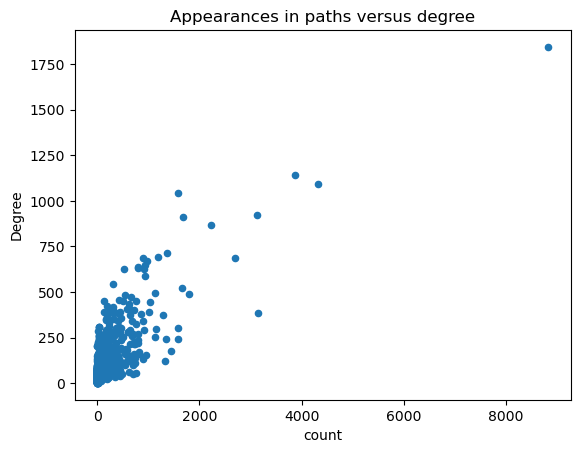

In [72]:
paths_finished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows=15,
                             names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "rating"])

# This is just splitting all the values in paths, and doing a value count for each one of those!
paths_per_step = paths_finished['path'].apply(lambda x: x.split(';')[1:-1])
node_appearance_counts = paths_per_step.explode().value_counts()
node_appearance_counts = node_appearance_counts.rename_axis('Node_Name').reset_index()

# For this, we add the information of the degree of each node, because it's interesting!
degree_dict = dict(wikispeedia.degree())
node_appearance_counts['Degree'] = node_appearance_counts['Node_Name'].map(degree_dict)

node_appearance_counts.plot.scatter('count', 'Degree')
plt.title('Appearances in paths versus degree')

In [76]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='count ~ Degree', data=node_appearance_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     5090.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:41:09   Log-Likelihood:                -22069.
No. Observations:                3405   AIC:                         4.414e+04
Df Residuals:                    3403   BIC:                         4.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.6768      3.364    -22.794      0.0

Based on the regression analysis, there is a correlation between how often a node is used in the paths and the degree. So this idea of players using a hub is definitely common for the human dataset.

We can also see that there is a high R squared, considering there is only one variable. So the degree does help explain how often it will appear in the paths.

Now, does this actually hold for the shortest paths?

Text(0.5, 1.0, 'Appearances in paths versus degree shortest paths')

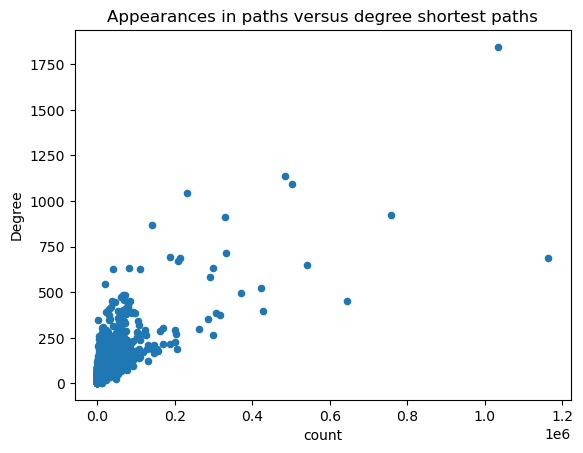

In [77]:
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# So, we also remove the first and last element in here
shortest_path_df = pd.DataFrame(shortest_path_dict)
shortest_path_df = pd.melt(shortest_path_df)
# This column is not useful
shortest_path_df = shortest_path_df.drop(['variable'], axis=1)
shortest_path_df = shortest_path_df['value'].dropna()
# This is to remove source and target, to keep the comparison similar
shortest_path_df = shortest_path_df.apply(lambda x: x[1:-1])
# This is to only keep lists that actually have at least one element
shortest_path_df = shortest_path_df[shortest_path_df.map(lambda x: len(x)>0)]

shortest_app_counts = shortest_path_df.explode().value_counts()
shortest_app_counts = shortest_app_counts.rename_axis('Node_Name').reset_index()
shortest_app_counts['Degree'] = shortest_app_counts['Node_Name'].map(degree_dict)

shortest_app_counts.plot.scatter('count', 'Degree')
plt.title('Appearances in paths versus degree shortest paths')

In [78]:
mod = smf.ols(formula='count ~ Degree', data=shortest_app_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     4771.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:43:17   Log-Likelihood:                -46255.
No. Observations:                3970   AIC:                         9.251e+04
Df Residuals:                    3968   BIC:                         9.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.118e+04    539.844    -20.715      0.0

While the R squared is lower, it is still quite high in this case. Most importantly, it also shows that there is a correlation between the degree and the number of times it appears in a shortest path!

So this implies that hubs are actually very helpful for finding out the path between two nodes, and are commonly used.

This is something that can be used in our AI, and maybe further in other analysis.

### 2.10. DataFrame and spreadsheet creation 

For future analysis, we may need to filter articles according to some metrics that we may have now or may create in the future. In order to speed up data handling and analysis, we will create the df and store it in a spreadsheet.

In [104]:
data = {}
# establish article name as index
articles_index = list(wikispeedia.nodes())
df = pd.DataFrame(data, index=articles_index)
# add main column
df['articles'] = articles_index
df['Degree'] = degrees.values()
df['PageRank'] = dic.values()
pd.set_option('display.precision', 15) # add precision to the df
df

articles  Degree  \
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in      11   
Bede                                                          Bede      39   
Columba                                                    Columba      23   
D%C3%A1l_Riata                                      D%C3%A1l_Riata      32   
Great_Britain                                        Great_Britain     215   
...                                                            ...     ...   
Yellowhammer                                          Yellowhammer      13   
Yotsuya_Kaidan                                      Yotsuya_Kaidan       2   
You%27re_Still_the_One                      You%27re_Still_the_One       2   
Yungay%2C_Peru                                      Yungay%2C_Peru       4   
Zara_Yaqob                                              Zara_Yaqob       6   

                                           PageRank  
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in  0.000032710390396  
Bede                              0.000219381613167  
Columba                           0.000121168818976  
D%C3%A1l_Riata                    0.000105560154678  
Great_Britain                     0.001506129246284  
...                                             ...  
Yellowhammer                      0.000032710390396  
Yotsuya_Kaidan                    0.000032710390396  
You%27re_Still_the_One            0.000032710390396  
Yungay%2C_Peru                    0.000032710390396  
Zara_Yaqob                        0.000032710390396  

[4592 rows x 3 columns]

Convert it into a excel

In [106]:
df.to_excel('wikispeedia.xlsx', index=False)

# 3. Ways to enrich, filter, transform the data

## 3.1 Semantic Similarity

An important part of the project is to study how humans and machines move from article to article. Semantic similarity compares two strings based on a trained model and assigns a value according to how are they correlated (the higher, the more related). For example, 'king' and 'queen' will have a higher semantic similarity than say, 'king' and 'chemistry' (will prove this here).

### Remove the underscore and decode the url

First we define a function that corrects the strings to have a readable format. For example, '%C3%89douard_Manet' is transformed to 'Édouard Manet'.

We will create a function to decode a word, and we will be able to use it in series and dataframes using apply().

In [79]:
def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

In [80]:
articles['articles'].head(5)

0    %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                          %C3%85land
2                  %C3%89douard_Manet
3                           %C3%89ire
4          %C3%93engus_I_of_the_Picts
Name: articles, dtype: object

In [81]:
articles['articles'].apply(decode_word).head(5)

0        Áedán mac Gabráin
1                    Åland
2            Édouard Manet
3                     Éire
4    Óengus I of the Picts
Name: articles, dtype: object

### Semantic Distance Model
We create a function that returns the semantic similarity between two words you provide.

In [107]:
# We define the model outside the function (make sure to run this before using the function)
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ImportError: 
BertModel requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [108]:
# Function to get embeddings (just because we will use it in semantic similarity function)
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Semantic similarity function
def semantic_similarity(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)
    return cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]

In [109]:
semantic_similarity('king', 'queen')

NameError: name 'tokenizer' is not defined

In [ ]:
semantic_similarity('king', 'chemistry')

### Semantic Distance Matrix
Provided a series, it creates a df where indices and column names are the strings of the series, and fills the matrix with the semantic similarity between all words in the provided series.

In [110]:
def semantic_similarity_matrix(titles):
    df = pd.DataFrame(index=titles, columns=titles)
    for i in range(len(titles)):
        for j in range(i+1, len(titles)):
            embedding1 = get_embedding(titles[i])
            embedding2 = get_embedding(titles[j])
            similarity = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]
            df.iloc[i, j] = similarity
            df.iloc[j, i] = similarity  # Copy value to lower triangle
            np.fill_diagonal(df.values, 1)
    return df

In [111]:
semantic_similarity_matrix(pd.Series(['king', 'queen', 'chemistry', 'biology']))

NameError: name 'tokenizer' is not defined

### PageRank

Let's create a graph visualization with node size according to the pagerank. 

In [5]:
nodos_greater_than_average = [n for n, data in wikispeedia.nodes(data=True) if 'pagerank' in data and data['pagerank'] > average]
# let's sort the nodes so that we can visualize the N elements greater than average
N = 60 # to avoid extra computing time try not to establish N higher than 80
# In this case, we chose N = 60 because 
nodes_ordered_per_pagerank = sorted(nodos_greater_than_average, key=lambda n: wikispeedia.nodes[n]['pagerank'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wavg = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wavg)

DiGraph with 0 nodes and 0 edges


In [7]:
def hierarchical_layout(net):
	return graphviz_layout(net, prog="dot")

node_labels = {node: node for node in wavg.nodes()}

pos = hierarchical_layout(wavg)
plt.figure(figsize=(50,50))
nx.draw(wavg,pos, node_size=[(wavg.nodes[n]['pagerank'] * 10500000) for n in wavg], node_color='skyblue', font_weight='bold', with_labels=True, labels=node_labels, font_color='purple', font_size=35, linewidths=8)
plt.title('Above average Pagerank Nodes', fontsize=100)
plt.show()

/var/folders/1v/llltq6dd3kdbnz0nqg8jny_00000gn/T/ipykernel_20439/3813012933.py:2: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  return graphviz_layout(net, prog="dot")


ModuleNotFoundError: No module named 'pydot'

### Let's draw the nodes with higher degree!

In [ ]:
print(degrees)
higher_degree = 300 # nodes that have at least 300 degree

NameError: name 'degrees' is not defined

Assign degree as node attribute of the wikispeedia graph

In [ ]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['degree'] = degrees[node]
print(wikispeedia.nodes(data=True))

In [ ]:
nodes_higher_degree = [n for n, data in wikispeedia.nodes(data=True) if 'degree' in data and data['degree'] >= higher_degree]
print(len(nodes_higher_degree))
# there is only 67 nodes with higher degree than 300, let's draw the first 60 to be in accordance with the other drawing and allow comparison

In [ ]:
# let's sort the nodes so that we can visualize the N elements greater than average
N = 60 
nodes_ordered_per_pagerank = sorted(nodes_higher_degree, key=lambda n: wikispeedia.nodes[n]['degree'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wdegree = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wdegree)

In [ ]:
def hierarchical_layout(net):
	return graphviz_layout(net, prog="dot")

node_labels = {node: node for node in wdegree.nodes()}

pos = hierarchical_layout(wdegree)
plt.figure(figsize=(50,50))
nx.draw(wdegree,pos, node_size=[(wdegree.nodes[n]['degree'] *80) for n in wdegree], node_color='orange', font_weight='bold', with_labels=True, labels=node_labels, font_color='purple', font_size=35, linewidths=10)
plt.title('Higher Degree Nodes', fontsize=100)
plt.show()

# 4. Plan and Ideas for Methods


## 4.1 Basic AI using A* Algorigm

Most of the model requires for there to be an AI model we can compare it against.

We were indicated by the TA to not focus on this too much, as this is a data analysis course, not an ML course. Because of this, we took the implementation of A\* that was included in networkX and created two modified versions that now do the following:
- First version returns all of the explored nodes, not just the shortest path found
- Second version is forced to do a depth first search without being able to return

For our purposes, the explored nodes is the most interesting metric, as it describes what were the links "clicked".

We found a paper that implements a more complicated version, and we might be able to do something with graph neural networks, but for now this is good enough.

We additionally do a bit of work to show how the system works timewise, as well as how the comparison will work in the future.

The time comparison is not super useful though, as that will depend on hardware too much to be worth using easily.

In [ ]:
import machine_searchers
import time

def modded_get_embedding(text: str):
    temp_str = text.replace('_', ' ')
    temp_str = unquote(temp_str)
    inputs = tokenizer(temp_str, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def distance_two_words(w1: str, w2: str):
    """Receives a string that was in the wikispeedia dataset, and transforms it as needed to work
    with the berd embeddings."""

    embedding1 = modded_get_embedding(w1)
    embedding2 = modded_get_embedding(w2)
    similarity = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]
    # Adding absolute, just in case it is needed
    # Similarity is actually 1 - abs(similarity) + 1,
    # As we want closer words to have a smaller distance
    # The last plus one is to indicate that there would be an extra cost to exploring, as if not the system often
    # thinks that there are nodes that have a distance of 0.5 or something like that
    similarity = 1 - abs(similarity) + 1
    # print("First word:", w1, ". Second word:", w2, ". GoodDistance:", similarity)
    return similarity

start_time = time.time()
lib_path_1, lib_explore_1 = machine_searchers.modded_astar_path(wikispeedia, 'Actor', 'Japan', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using the modded a star that returns explored nodes:")
print(" Found solution for Actor to Japan exploring the following number of nodes:", len(lib_explore_1)-1)
print(" Found it in:", end_time-start_time)

start_time = time.time()
lib_path_2, lib_explore_2 = machine_searchers.only_depth_first_astar_path(wikispeedia, 'Actor', 'Japan', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using depth first only A star that returns explored nodes:")
print(" Found solution for Actor to Japan exploring the following number of nodes:", len(lib_explore_1)-1)
print(" Found it in:", end_time-start_time)


Now we'll take the most commonly explored node pair path, run it through the two algorithms and see what is the result!

In [ ]:
# So it's finding the length between asteroid and viking
article_combinations.sort_values('count', ascending=False).head()

In [ ]:
start_time = time.time()
lib_path_1, lib_explore_1 = machine_searchers.modded_astar_path(wikispeedia, 'Asteroid', 'Viking', heuristic=distance_two_words)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using the modded a star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_1)-1)
print("Path length was:", len(lib_path_1)-1)
print(" Found it in:", end_time-start_time)

start_time = time.time()
lib_path_2, lib_explore_2 = machine_searchers.only_depth_first_astar_path(wikispeedia, 'Asteroid', 'Viking', heuristic=distance_two_words)
end_time = time.time()
print('')

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using depth first only A star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_2)-1)
print("Path length was:", len(lib_path_2)-1)
print(" Found it in:", end_time-start_time)

In [ ]:
lib_path_1

So, based on the previous example of the path, this works out well enough. The systems spends a lot of time exploring and going back, which might be a common issue. There is a huge disconnect between explored and actual path length, but that is common for A\*, so it's an expected caveat.

It is interesting to note that the optimal solution passed through Paris, which seems to fit the definition of being one of the hubs that are described in the paper. Maybe the hub strategy is actually useful in most cases!

The depth first method took a lot longer to run than planned. Based on this, it might be worth considering other alternatives.

But still, at least we've proven the model works, and can give results that we can compare against humans. Again, this is using a much simpler method, but this could be enhanced in the future.